In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sy
from simtk import openmm as mm
from simtk.openmm import app
import simtk.unit as unit

# Molecular dynamics

## With OpenMM

```python
import openmm as mm
from openmm import unit
from uibcdf_systems import TwoLJParticles

box=[[2.5, 0.0, 0.0], [0.0, 2.5, 0.0], [0.0, 0.0, 2.5]]*unit.nanometers
molecular_system = TwoLJParticles(atom_1='Ar', atom_2='Xe', box=box)

integrator = mm.LangevinIntegrator(300.0*unit.kelvin, 1.0/unit.picoseconds, 0.1*unit.picoseconds)
platform = Platform.getPlatformByName('CUDA')
simulation = Simulation(molecular_system.topology, molecular_system.system, integrator, platform)

coordinates=[[0.0, 0.0, 0.0], [1.0, 0.0, 0.0]]*unit.nanometers
simulation.context.setPositions(coordinates)

velocities = np.zeros([2, 3], np.float32) * unit.nanometers/unit.picoseconds
simulation.context.setVelocities(velocities)

simulation.step(1000)
```

## With this library

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from openmm import unit

from uibcdf_systems import TwoLJParticles
from uibcdf_systems.tools import langevin

box=[[2.5, 0.0, 0.0], [0.0, 2.5, 0.0], [0.0, 0.0, 2.5]]*unit.nanometers

molecular_system = TwoLJParticles(atom_1='Ar', atom_2='Xe', box=box)

### Newtonian dynamics

In [31]:
d_min = molecular_system.get_distance_minimum()
coordinates = np.zeros([2, 3], np.float32) * unit.nanometers
coordinates[0,0] = 1.0 * unit.nanometers
coordinates[1,0] = coordinates[0,0] + d_min + 0.05 * unit.angstroms

velocities = np.zeros([2, 3], np.float32) * unit.nanometers/unit.picoseconds

molecular_system.set_coordinates(coordinates)
molecular_system.set_velocities(velocities)

traj_dict = langevin(molecular_system,
                     friction=0.0/unit.picoseconds,
                     temperature=0.0*unit.kelvin,
                     time=10.0*unit.picoseconds,
                     saving_timestep=0.05*unit.picoseconds,
                     integration_timestep=0.05*unit.picoseconds)

  0%|          | 0/200 [00:00<?, ?it/s]

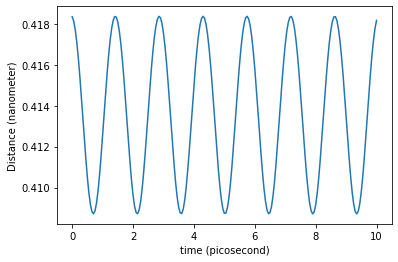

In [32]:
distance = traj_dict['coordinates'][:,1,0]-traj_dict['coordinates'][:,0,0]

plt.plot(traj_dict['time'], distance)
axes = plt.gca()
y_min, y_max = axes.get_ylim()
#plt.vlines(tau._value, y_min, y_max, linestyles='dashed', color='gray')
plt.xlabel('time ({})'.format(traj_dict['time'].unit))
plt.ylabel('Distance ({})'.format(distance.unit))
plt.show()

### Stochastic Dynamics

Thanks to the `tools.langevin` method in this library, a simple newtonian dynamics can be run with few effort:

In [33]:
d_min = molecular_system.get_distance_minimum()
coordinates = np.zeros([2, 3], np.float32) * unit.nanometers
coordinates[0,0] = 2.5/3.0 * unit.nanometers
coordinates[1,0] = 2.0*coordinates[0,0]

velocities = np.zeros([2, 3], np.float32) * unit.nanometers/unit.picoseconds

molecular_system.set_coordinates(coordinates)
molecular_system.set_velocities(velocities)

traj_dict = langevin(molecular_system,
                     friction=1.0/unit.picoseconds,
                     temperature=300.0*unit.kelvin,
                     time=200.0*unit.picoseconds,
                     saving_timestep=0.5*unit.picoseconds,
                     integration_timestep=0.05*unit.picoseconds)

  0%|          | 0/4000 [00:00<?, ?it/s]

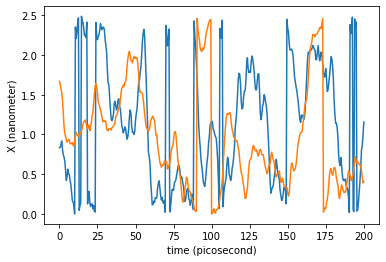

In [34]:
plt.plot(traj_dict['time'], traj_dict['coordinates'][:,0,0])
plt.plot(traj_dict['time'], traj_dict['coordinates'][:,1,0])
plt.xlabel('time ({})'.format(traj_dict['time'].unit))
plt.ylabel('X ({})'.format(traj_dict['coordinates'].unit))
plt.show()

The output coordinates are not wrapped into the periodic box, but this can be easily fixed with the library MolSysMT:

In [38]:
#import molsysmt as msm

#traj_dict_wrapped = msm.wrap_to_pbc(traj_dict)

In [39]:
#plt.plot(traj_dict_wrapped['time'], traj_dict_wrapped['coordinates'][:,0,0])
#plt.plot(traj_dict_wrapped['time'], traj_dict_wrapped['coordinates'][:,1,0])
#plt.xlabel('time ({})'.format(traj_dict['time'].unit))
#plt.ylabel('X ({})'.format(traj_dict['coordinates'].unit))
#plt.show()

Let's also check the evolution in time of the distance between both particles. This can also be computed with MolSysMT:

In [40]:
#distance = msm.distance(traj_dict, selection=0, selection_2=1, pbc=True)

In [41]:
#plt.plot(traj_dict['time'], distance[:,0,0])
#plt.xlabel('time ({})'.format(traj_dict['time'].unit))
#plt.ylabel('X ({})'.format(distance.unit))
#plt.show()

Finnally, let's show the evolution of the system in a three-dimensional representation:

In [42]:
#from mpl_toolkits.mplot3d import Axes3D
#import matplotlib.animation as animation

In [43]:
#traj=traj_dict_wrapped['coordinates']._value
#radius=0.5*x_min.in_units_of(unit.nanometers)._value

#plt.rcParams["animation.html"] = "jshtml"

#fig = plt.figure()
#ax = fig.add_subplot(projection='3d')

#ax.set_title("Two LJ atoms in cubic box")
#ax.set_xlim([-1.0, 1.0])
#ax.set_ylim([-1.0, 1.0])
#ax.set_zlim([-1.0, 1.0])

#dots = []
#for ii in range(2):
#    dots.append(ax.scatter(traj[0,ii,0], traj[0,ii,1], traj[0,ii,2], marker="o", color='b'))

#def animate(frame, traj, dots):

#    for ii in range(2):
#        dots[ii].remove()
#        dots[ii]=ax.scatter(traj[frame,ii,0], traj[frame,ii,1], traj[frame,ii,2], marker="o", color='b')

#    return spheres

#frame=0
    
#ani = animation.FuncAnimation(fig, animate, fargs=(traj, dots), frames=200,
#                              interval=50, blit=False)
#plt.close()
#ani

In [44]:
#msm.view([open_molecular_system, traj_dict_wrapped])

-------------

**Sources**

http://docs.openmm.org/6.3.0/userguide/theory.html#lennard-jones-interaction
https://openmmtools.readthedocs.io/en/0.18.1/api/generated/openmmtools.testsystems.LennardJonesPair.html
https://openmmtools.readthedocs.io/en/latest/api/generated/openmmtools.testsystems.LennardJonesFluid.html
https://gpantel.github.io/computational-method/LJsimulation/